# Working with SeismicBatch

## Content
* [Indexing data](#Indexing-data)
* [Actions](#actions)
    * [Load](#Load)
    * [Visualization](#Visualization)
    * [Sorting](#Sorting)
    * [Signal processing](#Signal-processing)
    * [Dump](#Dump)
    * [Merge](#Merge)

## Indexing data

Work with seismic data starts with data indexing. See the tutorial on index to recall different index types. Here we consider ```FieldIndex``` that enumerates field records of two components named ```raw``` and ```lift```:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import segyio

sys.path.append('..')

from batchflow import Dataset
from geolog import SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex

path_raw = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'
path_lift = '/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
               .merge(FieldIndex(name='lift', path=path_lift)))

field_index.head()

,file_id,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE
,raw,,,raw,lift,lift
FieldRecord,,,,,,
111906,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy,1656,35,1,/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy,1
111906,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy,1657,36,2,/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy,2
111906,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy,1655,78,3,/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy,3
111906,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy,1658,79,4,/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy,4
111906,/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy,1654,127,5,/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy,5


## Actions

### Load

Action ```load``` reads sets of traces from SEGY files and stores them in batch components. You can manage which components to load setting ```components``` parameter. Depending on batch index type each set of traces is represended by a signle trace (in case of ```TraceIndex```), or traces that correspond to a single field record (in case of ```FieldIndex```), or all traces from a single bin (in case of ```BinsIndex```) etc.

For each component traces are loaded in a default ```TraceNumber``` order. This can be manipulated by the ```sort_by``` parameters.

Finally, one can load not the whole trace but its specific slice. Use ```tslice``` parameter to specify which slice to load. To illustrate this, let's load ```raw``` and ```lift``` components in ```offset``` order and only first 3000 samples:

In [2]:
batch = (Dataset(field_index, SeismicBatch).next_batch(10)
         .load(components=['raw', 'lift'], sort_by='offset', tslice=slice(3000)))

Note the batch item contains a number of traces grouped by common field record rather than a single trace

In [3]:
batch.raw[0].shape

(3456, 3000)

In contrast, working with ```TraceIndex``` we will load single traces in batch items:

In [4]:
trace_batch = (Dataset(TraceIndex(field_index), SeismicBatch).next_batch(10)
              .load(components=['raw', 'lift'], tslice=slice(3000)))

trace_batch.raw[0].shape

(3000,)

### Visualisation

One can show a single batch item or use an interactive tool to scroll with a mouse over batch items and show each of them.

To show traces in a single batch item use ```show_traces``` action. This will output traces in a 2D plot using ```matplotlib.pyplot.imshow```. Any kwargs except for ```figsize``` passed to ```show_traces``` will be passed to ```imshow```. E.g. let's show traces of batch component ```raw``` with index ```111906``` in a grayscale mode and also clip maximal and minimal values:

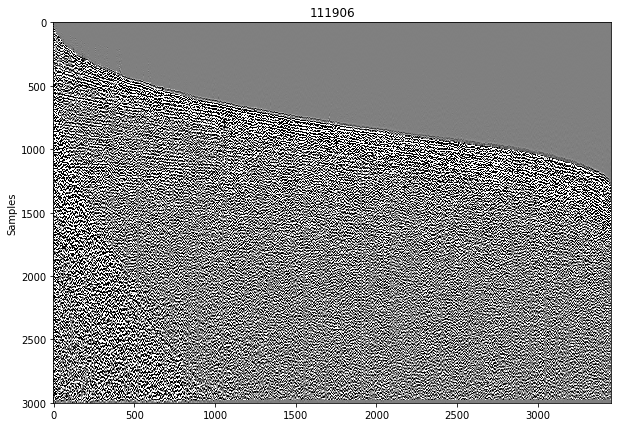

In [5]:
cv = 0.1
batch.show_traces('raw', 111906, figsize=(10, 7), vmin=-cv, vmax=cv, cmap='gray')

To interactively iterate over batch items use ```items_viewer```:

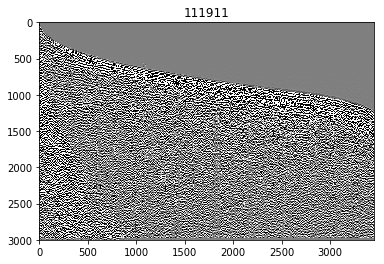

In [6]:
fig, tracker = batch.items_viewer('raw', vmin=-cv, vmax=cv, cmap='gray')
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

### Sorting

Trace sorting order can be changed by ```sort_traces``` action:

In [7]:
batch.sort_traces(src='raw', dst='raw', sort_by='TraceNumber')

Show traces in new sorting:

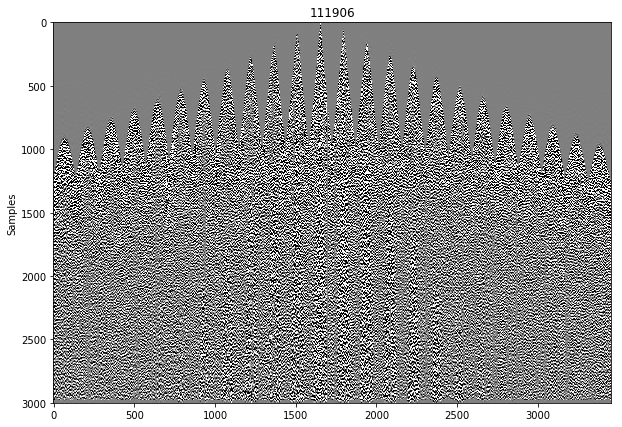

In [8]:
batch.show_traces('raw', 111906, figsize=(10, 7), vmin=-cv, vmax=cv, cmap='gray')

### Signal processing

There is a number of built-in signal processing methods that can be applied to traces, e.g. Fourier transform, gradient or various wavelet transforms. E.g. consider gradient and Fourier transform:

In [9]:
batch.gradient(src='raw', dst='grad_raw')
batch.rfft(src='raw', dst='fft_raw')

Besides built-in methods, any custom fuction can be applied either to batch item or to each trace within batch item. For example, let's take an absolute value for the above transformed traces:

In [10]:
batch.apply_to_trace(abs, src='fft_raw', dst='fft_raw')

Show the spectrum:

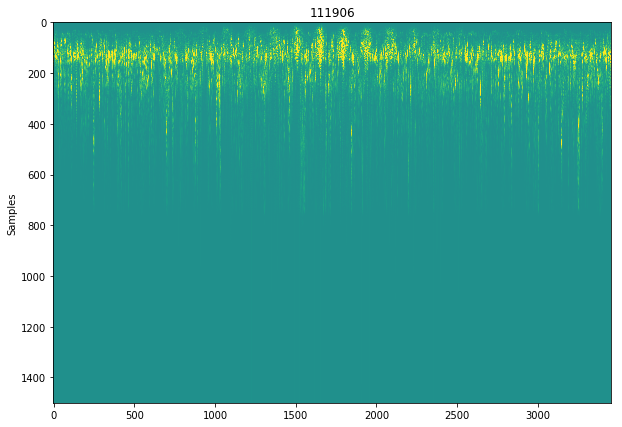

In [11]:
cv = 100
batch.show_traces('fft_raw', 111906, figsize=(10, 7), vmin=-cv, vmax=cv)

### Dump

Batch components can be dumped in segy file format by ```dump_segy``` action. There are two options: dump each component item in a separate file (then ```split=True```) or dump all traces in a single file (then ```split=False```). 

### Merge

Several SEGY files can be concatenated in a single SEGY file. Action ```merge_segy_files``` will append each indexed segy file to the output file. To illustrate this, let's index several SEFY files:

In [12]:
segy_index = SegyFilesIndex(path='/notebooks/egor/noise_data/DN0*.sgy', name='raw')
print(segy_index.indices)

Index(['/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy',
       '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy',
       '/notebooks/egor/noise_data/DN03_SHOTS_LIFT2.sgy',
       '/notebooks/egor/noise_data/DN04_SHOTS_LIFT3.sgy'],
      dtype='object', name=('file_id', 'raw'))


and merge these files into single one:

In [13]:
dump_path = '/notebooks/egor/geolog/notebooks/dumps/merged.sgy'

(Dataset(segy_index, SeismicBatch).next_batch(len(segy_index))
 .merge_segy_files(path=dump_path, component='raw'))

Enjoy!